# User Behavior Analysis and A/A/B Experiment Evaluation for a Food Retail App

## 🧪 Project Overview

### **Context / Stakeholder**

The stakeholder is a startup company operating in the food retail industry, offering its services through a mobile application.

### **Objective**

The goal of this analysis is twofold:

1. To examine user behavior within the mobile app by studying the sales funnel and identifying stages where user drop-off occurs.
2. To assess the results of an A/A/B experiment designed to evaluate whether a change in the app’s font impacts user behavior.

### **Business Tasks**

* Analyze the sequence of in-app user actions to construct a conversion funnel.
* Identify the proportion of users reaching each stage and determine where the greatest drop-offs occur.
* Calculate the overall conversion rate from the first event to the final purchase.
* Evaluate the performance of the experimental group (with a new font) against two control groups (with the original font) using statistical hypothesis testing.
* Determine whether the font change had a statistically significant impact on user behavior.

### **Experimental Design**

The experiment involved three groups:

* Group 246 — control group (original font)
* Group 247 — control group (original font)
* Group 248 — experimental group (new font)

The use of two control groups allows for validation of the experimental setup. If groups 246 and 247 yield similar results, the test is considered well-balanced. Any significant difference between these control groups may indicate confounding factors or data issues.

### **Dataset**

The dataset was provided as part of the **Yandex Practicum Data Analyst training program** (practicum.yandex).

Each row in the dataset represents a logged user event with the following columns:

* `event_name`: Type of user action
* `device_id`: Unique identifier for the user
* `event_timestamp`: Date and time of the event
* `exp_id`: Experimental group ID (246, 247, or 248)

### **Tools and Libraries**

* Python
* pandas
* matplotlib / seaborn
* scipy
* Jupyter Notebook

### Note
To make the results more interpretable, the experimental group IDs are renamed as follows:

Group 246 → A_1 (Control Group 1)
Group 247 → A_2 (Control Group 2)
Group 248 → B (Experimental Group – new font design)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from scipy import stats as st
from datetime import datetime, timedelta
from plotly import graph_objects as go 

from scipy import stats as st
import numpy as np
import math as mth

pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
file_path = "logs_exp.csv"

if os.path.exists(file_path):
    df = pd.read_csv(file_path, sep='\t')
else:
    raise FileNotFoundError(f"File not found: {file_path}")

In [3]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Renaming columns and adding new columns for datetime and date.

In [4]:
df.columns= ['event_name','device_id', 'event_timestamp','exp_id']

In [5]:

df['event_date_time'] = pd.to_datetime(df['event_timestamp'], unit='s')
df['date'] = df['event_date_time'].dt.date

In [6]:
df.head()

,event_name,device_id,event_timestamp,exp_id,event_date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [7]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
def general_info(df):
    print("Number of duplicate rows:", df.duplicated().sum())
    print("\nFirst 5 rows:")
    display(df.head())
    
    print("\nDataFrame Info:")
    display(df.info())
    
    print("\nColumn Names:")
    display(df.columns)
    
    print("\nMissing Values (Proportion):")
    display(df.isna().mean())


In [9]:
general_info(df)

Number of duplicate rows: 413

First 5 rows:


,event_name,device_id,event_timestamp,exp_id,event_date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   device_id        244126 non-null  int64         
 2   event_timestamp  244126 non-null  int64         
 3   exp_id           244126 non-null  int64         
 4   event_date_time  244126 non-null  datetime64[ns]
 5   date             244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


None


Column Names:


Index(['event_name', 'device_id', 'event_timestamp', 'exp_id',
       'event_date_time', 'date'],
      dtype='object')


Missing Values (Proportion):


event_name        0.00
device_id         0.00
event_timestamp   0.00
exp_id            0.00
event_date_time   0.00
date              0.00
dtype: float64

413 duplicate rows were found.

In [10]:
duplicated_df = df[df.duplicated(keep=False)]

In [11]:
display(duplicated_df.sort_values(by='device_id').head())

,event_name,device_id,event_timestamp,exp_id,event_date_time,date
130995,OffersScreenAppear,33176906322804559,1564933763,248,2019-08-04 15:49:23,2019-08-04
130994,OffersScreenAppear,33176906322804559,1564933763,248,2019-08-04 15:49:23,2019-08-04
130558,MainScreenAppear,33176906322804559,1564933075,248,2019-08-04 15:37:55,2019-08-04
130557,MainScreenAppear,33176906322804559,1564933075,248,2019-08-04 15:37:55,2019-08-04
104106,CartScreenAppear,34565258828294726,1564857221,248,2019-08-03 18:33:41,2019-08-03


In [12]:
num_duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {num_duplicates}')
print(f'share of duplicates: {num_duplicates/len(df)*100}')

Number of duplicate rows: 413
share of duplicates: 0.16917493425526162


In [13]:
df = df.drop_duplicates().reset_index(drop = True)

All exact duplicates have been removed. There are no missing values. The data has been formatted as needed, and all column names have been converted to lowercase.

## Data Exploration

In [14]:
df.head(3)

,event_name,device_id,event_timestamp,exp_id,event_date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25


### Events in the Log

In [15]:
df['event_name'].describe()

count               243713
unique                   5
top       MainScreenAppear
freq                119101
Name: event_name, dtype: object

In [16]:
df['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

### Users

In [17]:
df['device_id'].nunique()

7551

If we assume that `device_id` represents a unique user, then the dataset contains a total of 7,551 users.

#### What is the average number of events per user?

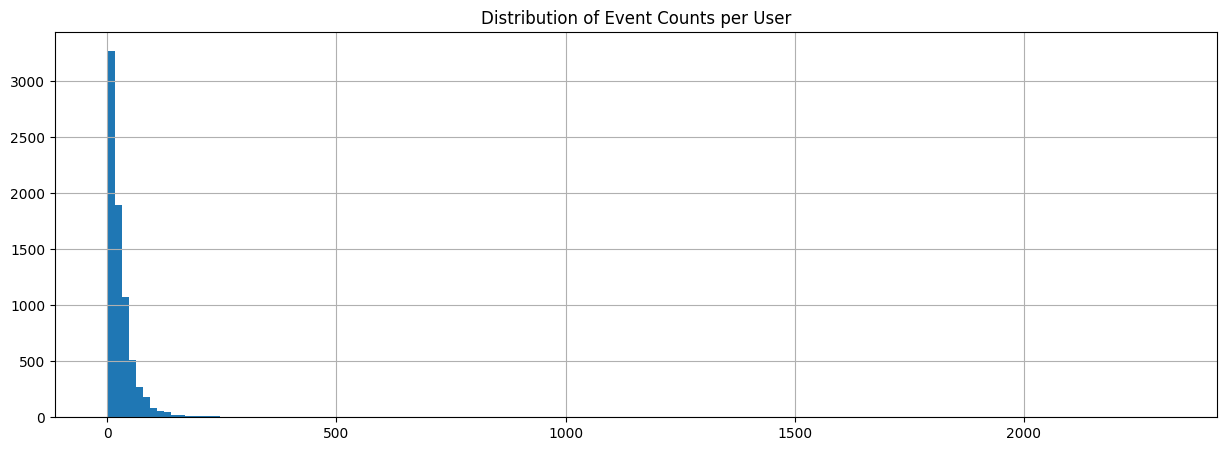

In [18]:
plt.figure(figsize=(15, 5))
df.groupby('device_id')['event_name'].count().sort_values(ascending = False).hist(bins = 150)
plt.title('Distribution of Event Counts per User')
plt.show()

In [19]:
df.groupby('device_id')['event_name'].count().sort_values(ascending = False).describe()

count   7,551.00
mean       32.28
std        65.15
min         1.00
25%         9.00
50%        20.00
75%        37.00
max     2,307.00
Name: event_name, dtype: float64

### Average Number of Events per User

Due to the wide spread in the number of events per user, we use the **median** as a more robust measure of central tendency.

**Result:** On average, each user performs **20 events**.


### Checking Data by Date

In [20]:
df.sort_values(by = 'event_date_time',ascending = False).head()

,event_name,device_id,event_timestamp,exp_id,event_date_time,date
243712,OffersScreenAppear,5746969938801999050,1565212517,246,2019-08-07 21:15:17,2019-08-07
243711,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07
243710,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
243709,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
243708,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07


In [21]:
df['event_date_time'].describe()

count                           243713
mean     2019-08-04 10:19:17.987665920
min                2019-07-25 04:43:36
25%                2019-08-02 14:36:45
50%                2019-08-04 11:51:00
75%                2019-08-06 06:56:24
max                2019-08-07 21:15:17
Name: event_date_time, dtype: object

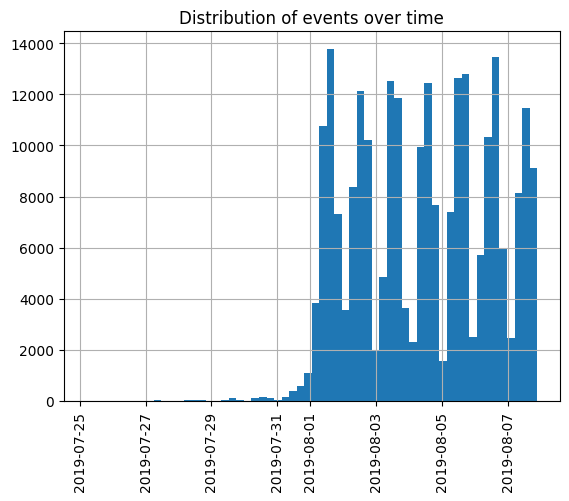

In [22]:
dd = df['event_date_time'].hist(bins = 60)

dd.tick_params(axis = 'x', labelrotation = 90)

plt.title('Distribution of events over time')
plt.show()


The histogram shows that the majority of data is concentrated between August 1 and August 7, 2019.
I will now take a closer look at the data from July 25 to August 1, 2019, to assess its completeness and consistency.

In [23]:
incomplete_data = df.query('event_date_time < "2019-08-01"')

In [24]:
incomplete_data.sort_values(by = 'device_id').head()

,event_name,device_id,event_timestamp,exp_id,event_date_time,date
382,MainScreenAppear,19151588103329050,1564436151,248,2019-07-29 21:35:51,2019-07-29
479,OffersScreenAppear,32131536909829030,1564480165,247,2019-07-30 09:49:25,2019-07-30
1907,MainScreenAppear,33176906322804559,1564601363,248,2019-07-31 19:29:23,2019-07-31
1805,OffersScreenAppear,33589551945846495,1564597381,248,2019-07-31 18:23:01,2019-07-31
1782,MainScreenAppear,38880205595577265,1564596510,248,2019-07-31 18:08:30,2019-07-31


In [25]:
incomplete_data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [26]:

print('Share of incomplete data in the dataset:', round(len(incomplete_data)/len(df)*100,2))


Share of incomplete data in the dataset: 1.16


In [27]:
print('Total events recorded before 01.08.2019:',len(incomplete_data))

Total events recorded before 01.08.2019: 2826


In [28]:
print('Number of users before 01.08.2019:',incomplete_data['device_id'].nunique())

Number of users before 01.08.2019: 1451


The data prior to 01.08.2019 accounts for 1.16% of the total. This includes 1451 unique users and 2826 events.

After discarding the incomplete data, I will save the remaining dataset as `full_data`

In [29]:
full_data = df.query('event_date_time >= "2019-08-01"')
full_data.sort_values(by = ['device_id','event_date_time']).reset_index(drop=True).head()

,event_name,device_id,event_timestamp,exp_id,event_date_time,date
0,MainScreenAppear,6888746892508752,1565100394,246,2019-08-06 14:06:34,2019-08-06
1,MainScreenAppear,6909561520679493,1565117574,247,2019-08-06 18:52:54,2019-08-06
2,PaymentScreenSuccessful,6909561520679493,1565117578,247,2019-08-06 18:52:58,2019-08-06
3,CartScreenAppear,6909561520679493,1565117578,247,2019-08-06 18:52:58,2019-08-06
4,MainScreenAppear,6909561520679493,1565117578,247,2019-08-06 18:52:58,2019-08-06


Let's examine the data by test groups.

In [30]:
full_data.groupby(by = 'exp_id')['device_id'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: device_id, dtype: int64

The remaining dataset includes users from all three groups.

## Event Funnel Analysis

### What events are recorded in the logs, and how frequently do they occur?

In [31]:
full_data.groupby('event_name')['event_name'].count().sort_values(ascending=False)

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [32]:
len(full_data)

240887

There are 5 distinct events in the logs. The most frequently occurring event is `MainScreenAppear`.

### Number of Users Who Performed Each Event
This step involves calculating how many unique users triggered each event at least once. It helps us understand user engagement with different parts of the application.

In [33]:
count_by_users = full_data.groupby('event_name')['device_id'].nunique().sort_values(ascending=False).reset_index()
full_data['device_id'].nunique()


7534

In [34]:
count_by_users

,event_name,device_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [35]:
count_by_users.columns = ['event_name','users_total']
count_by_users['share,%'] = count_by_users['users_total']/df['device_id'].nunique()*100
count_by_users

,event_name,users_total,"share,%"
0,MainScreenAppear,7419,98.25
1,OffersScreenAppear,4593,60.83
2,CartScreenAppear,3734,49.45
3,PaymentScreenSuccessful,3539,46.87
4,Tutorial,840,11.12


The table above shows both the absolute and relative number of users who performed each of the listed events at least once.

### Events order

It appears that most users tend to follow this sequence of actions:

* Open the Main Screen.
* Then proceed to the Offers Screen.
* Next, move to the Cart.
* Finally, make a Purchase.

However, the Tutorial section is viewed by very few users.


In [36]:
fig = go.Figure(
    go.Funnel(
        y=[
            'Main Screen Viewed',
            'Offers Screen Viewed',
            'Cart Accessed',
            'Purchase Completed'

,
        ],
        x=count_by_users["users_total"], 
    )
)

fig.update_layout(
    title="Event Funnel",font=dict(
        family="Courier New, monospace",
        size=16,
        color="RebeccaPurple"))

fig.show() 

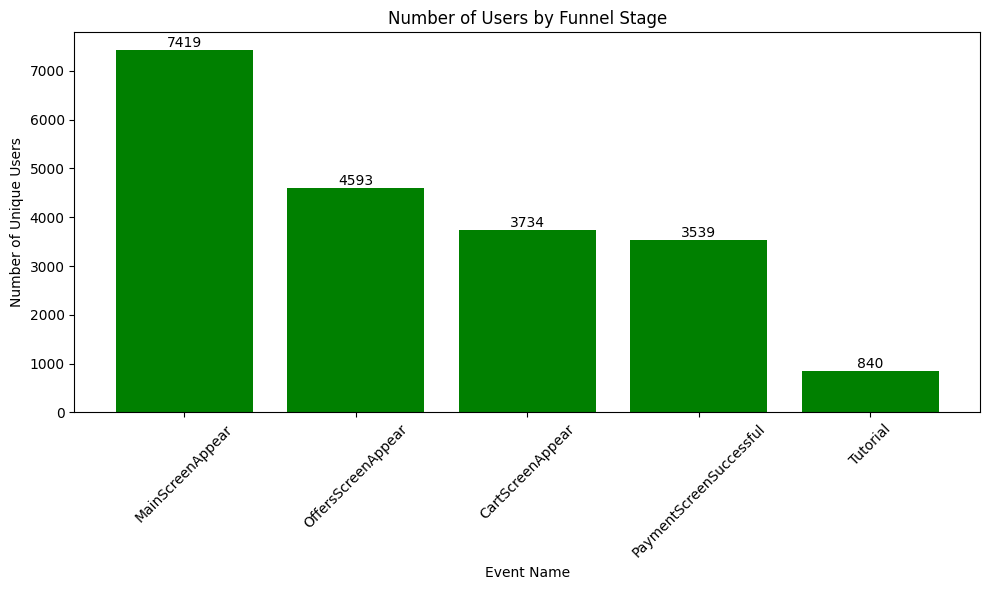

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(count_by_users['event_name'], count_by_users['users_total'], color='green')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,   # x position (center of the bar)
        height,                              # y position (top of the bar)
        f'{int(height)}',                    # label text
        ha='center', va='bottom'             # alignment
    )

ax.set_title('Number of Users by Funnel Stage')
ax.set_xlabel('Event Name')
ax.set_ylabel('Number of Unique Users')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



**Funnel Analysis Findings:**

* **61.9%** of users who opened the main screen proceeded to the offers screen.
* **81.3%** of those who visited the offers screen moved to the cart to place an order.
* **94.6%** of users who accessed the cart completed a purchase.
* In total, **47.7%** of users progressed from the initial event (Main Screen Viewed) to the final event (Purchase Completed).

The largest drop-off occurs at the very first step — after viewing the main screen.


## Analysis of Experiment Results

In this section, we will analyze the A/A/B experiment conducted by the company. The purpose of the experiment was to assess the impact of a new font on user behavior in the mobile application.

There are three groups in the dataset:
- **Group 246**: Control Group A_1 (old font)
- **Group 247**: Control Group A_2 (old font)
- **Group 248**: Experimental Group B (new font)

### Number of unique users per experiment group

In [38]:
df = df.reset_index(drop = True)

I will replace the experiment IDs with letter labels:

246 → A_1

247 → A_2

248 → B


In [39]:
full_data['exp_id'] = full_data['exp_id'].replace(246,'A_1')
full_data['exp_id'] = full_data['exp_id'].replace(247,'A_2')
full_data['exp_id'] = full_data['exp_id'].replace(248,'B')

In [40]:
full_data.head()

,event_name,device_id,event_timestamp,exp_id,event_date_time,date
2826,Tutorial,3737462046622621720,1564618048,A_1,2019-08-01 00:07:28,2019-08-01
2827,MainScreenAppear,3737462046622621720,1564618080,A_1,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,A_1,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,A_1,2019-08-01 00:08:58,2019-08-01
2830,MainScreenAppear,1433840883824088890,1564618139,A_2,2019-08-01 00:08:59,2019-08-01


In [41]:
full_data.groupby(by = 'exp_id')['device_id'].nunique()

exp_id
A_1    2484
A_2    2513
B      2537
Name: device_id, dtype: int64

The groups can be considered equal in size, with only a minor difference of about 1% between A\_1 and A\_2.


In [42]:
A_1_group = full_data.query('exp_id == "A_1"')
A_2_group = full_data.query('exp_id == "A_2"')
B_group = full_data.query('exp_id == "B"')

In [43]:
A_1_group.head()

,event_name,device_id,event_timestamp,exp_id,event_date_time,date
2826,Tutorial,3737462046622621720,1564618048,A_1,2019-08-01 00:07:28,2019-08-01
2827,MainScreenAppear,3737462046622621720,1564618080,A_1,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,A_1,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,A_1,2019-08-01 00:08:58,2019-08-01
2832,OffersScreenAppear,3737462046622621720,1564618226,A_1,2019-08-01 00:10:26,2019-08-01


Retrieving funnel data for group A\_1:


In [44]:
A_1_funnel= A_1_group.query(
    'event_name != "Tutorial"').groupby(
    by = 'event_name')['device_id'].nunique().sort_values(ascending=False).reset_index()
A_1_funnel.columns = ['event_name','users_A_1']

In [45]:
A_1_funnel

,event_name,users_A_1
0,MainScreenAppear,2450
1,OffersScreenAppear,1542
2,CartScreenAppear,1266
3,PaymentScreenSuccessful,1200


Retrieving funnel data for group A_2:

In [46]:
A_2_funnel= A_2_group.query(
    'event_name != "Tutorial"').groupby(
    by = 'event_name')['device_id'].nunique().sort_values(ascending=False).reset_index()
A_2_funnel.columns = ['event_name','users_A_2']

In [47]:
A_2_funnel

,event_name,users_A_2
0,MainScreenAppear,2476
1,OffersScreenAppear,1520
2,CartScreenAppear,1238
3,PaymentScreenSuccessful,1158


Retrieving funnel data for group B:

In [48]:
B_funnel= B_group.query(
    'event_name != "Tutorial"').groupby(
    by = 'event_name')['device_id'].nunique().sort_values(ascending=False).reset_index()
B_funnel.columns = ['event_name','users_B']

In [49]:
B_funnel

,event_name,users_B
0,MainScreenAppear,2493
1,OffersScreenAppear,1531
2,CartScreenAppear,1230
3,PaymentScreenSuccessful,1181


All three groups together.

In [50]:
funnels = A_1_funnel.merge(A_2_funnel, on = 'event_name', how = 'left'
                          ).merge(B_funnel,on = 'event_name',how = 'left')
# add united control group AA:

funnels['users_AA'] = funnels['users_A_1']+funnels['users_A_2']

In [51]:
funnels

,event_name,users_A_1,users_A_2,users_B,users_AA
0,MainScreenAppear,2450,2476,2493,4926
1,OffersScreenAppear,1542,1520,1531,3062
2,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358


### Z test

To compare the conversion rates between groups in the A/A/B experiment, we applied a **Z-test for proportions**. This test is appropriate in our case for the following reasons:

- **We are comparing proportions**, not means — specifically, the proportion of users who completed each step of the funnel within each experimental group.
- **Sample sizes in all groups are large (thousands of users)**, which satisfies the conditions for using the Z-test. According to the Central Limit Theorem, with a large sample size, the sampling distribution of proportions approximates a normal distribution.

Because of these factors, the Z-test is the most suitable method for evaluating whether the observed differences in conversion rates are statistically significant.


To ensure the reliability of the subsequent A/B test, we will first conduct an A/A test. The goal is to confirm that the two control groups, A_1 and A_2, perform similarly and that the application behaves consistently for both.

Before testing, we formulate the following hypotheses:

H₀ (Null Hypothesis): There is no statistically significant difference in conversion rates between groups A_1 and A_2.

H₁ (Alternative Hypothesis): There is a statistically significant difference in conversion rates between groups A_1 and A_2.



In [52]:
### Z-Test Function to Compare Proportions Between Two Groups

#The function below is used to compare conversion rates (proportions) between two independent groups
# using a two-tailed z-test. It helps evaluate whether the observed differences in proportions are statistically significant.


def z_test(trials, successes, alpha):
    # Proportion of successes in the first group:
    p1 = successes[0] / trials[0]

    # Proportion of successes in the second group:
    p2 = successes[1] / trials[1]

    # Combined success proportion across both groups:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # Difference between the two proportions:
    difference = p1 - p2 

    # Calculate the z-statistic using the formula for the standard error:
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1])
    )

    # Standard normal distribution (mean = 0, std = 1):
    distr = st.norm(0, 1)

    # Two-tailed p-value:
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value:', p_value)

    if p_value < alpha:
        print('Reject the null hypothesis: there is a statistically significant difference between the proportions')
    else:
        print('Fail to reject the null hypothesis: no statistically significant difference between the proportions')


In [53]:
funnels.itertuples()

In [54]:
# Get the number of users in each control group (A_1 = 246, A_2 = 247)
total_in_groups = list(full_data.groupby(by='exp_id')['device_id'].nunique())

# Loop through each funnel step and perform the z-test
for row in funnels.itertuples():
    print('_____________')
    print(row.event_name)

    z_test(total_in_groups, [row.users_A_1, row.users_A_2], alpha=0.05)

_____________
MainScreenAppear
p-value: 0.7570597232046099
Fail to reject the null hypothesis: no statistically significant difference between the proportions
_____________
OffersScreenAppear
p-value: 0.2480954578522181
Fail to reject the null hypothesis: no statistically significant difference between the proportions
_____________
CartScreenAppear
p-value: 0.22883372237997213
Fail to reject the null hypothesis: no statistically significant difference between the proportions
_____________
PaymentScreenSuccessful
p-value: 0.11456679313141849
Fail to reject the null hypothesis: no statistically significant difference between the proportions


In [55]:
total_in_groups

[2484, 2513, 2537]

Z-test results for groups A_1 and A_2 showed that there is no reason to consider the proportions in the samples significantly different. 

### Events Comparison::

In [56]:
funnels

,event_name,users_A_1,users_A_2,users_B,users_AA
0,MainScreenAppear,2450,2476,2493,4926
1,OffersScreenAppear,1542,1520,1531,3062
2,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358


In [57]:
total_in_groups

[2484, 2513, 2537]

Now I calculate the **conversion rates** for each event across the experimental groups (A_1, A_2, B) and the combined control group (A_1 + A_2). The conversion rate here refers to the percentage of users in each group who performed a specific event.

In [58]:
funnels['share_A_1,%'] = funnels['users_A_1']/total_in_groups[0]*100
funnels['share_A_2,%'] = funnels['users_A_2']/total_in_groups[1]*100
funnels['share_B,%'] = funnels['users_B']/total_in_groups[2]*100
funnels['share_AA,%'] = funnels['users_AA']/(total_in_groups[0] + total_in_groups[1])*100

In [59]:
funnels

,event_name,users_A_1,users_A_2,users_B,users_AA,"share_A_1,%","share_A_2,%","share_B,%","share_AA,%"
0,MainScreenAppear,2450,2476,2493,4926,98.63,98.53,98.27,98.58
1,OffersScreenAppear,1542,1520,1531,3062,62.08,60.49,60.35,61.28
2,CartScreenAppear,1266,1238,1230,2504,50.97,49.26,48.48,50.11
3,PaymentScreenSuccessful,1200,1158,1181,2358,48.31,46.08,46.55,47.19


In [60]:
#main_screen_appear = list(funnels.loc[0,['users_A_1','users_B']])
#main_screen_appear

In [61]:
total_in_groups = list(full_data.groupby(by = 'exp_id')['device_id'].nunique())
total_in_groups

[2484, 2513, 2537]

For further calculations, I need to determine the initial number of users in groups B and AA, respectively.

In [62]:
total_in_groups_AA = total_in_groups[0]+total_in_groups[1]

# creating an array
total_in_groups_AA_B = np.array([total_in_groups[2],total_in_groups_AA])
print(total_in_groups_AA_B)

[2537 4997]


## A/B Testing by Events

A total of 16 z-tests will be conducted (4 events across 4 group comparisons).  
Therefore, using the Bonferroni correction, I will adjust the significance level (alpha) by dividing it by the number of comparisons — that is, by 16.


### Hypotheses for A/B Testing

- **H₀ (Null Hypothesis):** There is no statistically significant difference in conversion rates between the groups.
- **H₁ (Alternative Hypothesis):** There is a statistically significant difference in conversion rates between the groups.

The critical significance level (alpha) is adjusted using the Bonferroni correction.


In [63]:
 for row in funnels.itertuples():
    print('____***____')    
    print(row.event_name)
    print('____***____')  
    print('Comparing A_1 vs A_2:')
    z_test(total_in_groups, [row.users_A_1, row.users_A_2], alpha = .05/16)
    print('__________')
    print('Comparing A_1 vs B:')
    z_test(total_in_groups[::2],[row.users_A_1,row.users_B],alpha = .05/16)
    print('__________')
    print('Comparing A_2 vs B:')
    z_test(total_in_groups[1:],[row.users_A_2,row.users_B],alpha = .05/16)
    print('__________')
    print('Comparing B vs AA:')
    z_test(total_in_groups_AA_B,[row.users_B,row.users_AA],alpha = .05/16)
    
    

____***____
MainScreenAppear
____***____
Comparing A_1 vs A_2:
p-value: 0.7570597232046099
Fail to reject the null hypothesis: no statistically significant difference between the proportions
__________
Comparing A_1 vs B:
p-value: 0.2949721933554552
Fail to reject the null hypothesis: no statistically significant difference between the proportions
__________
Comparing A_2 vs B:
p-value: 0.4587053616621515
Fail to reject the null hypothesis: no statistically significant difference between the proportions
__________
Comparing B vs AA:
p-value: 0.29424526837179577
Fail to reject the null hypothesis: no statistically significant difference between the proportions
____***____
OffersScreenAppear
____***____
Comparing A_1 vs A_2:
p-value: 0.2480954578522181
Fail to reject the null hypothesis: no statistically significant difference between the proportions
__________
Comparing A_1 vs B:
p-value: 0.20836205402738917
Fail to reject the null hypothesis: no statistically significant difference bet

## Results

#### Testing Groups for the Event: "MainScreenAppear"


Out of the total number of app users in each group, the following proportions accessed the Main Screen (MainScreenAppear):

Group A_1 – 98.63% of 2,489 users

Group A_2 – 98.53% of 2,513 users

Group B – 98.27% of 2,537 users

Combined control group AA – 98.58% of 4,997 users

A z-test conducted across all 4 groups for the "Main Screen Opened" event showed that there are **no statistically significant differences between the groups**.

#### Testing Groups for the Event: "OffersScreenAppear"

Out of the total number of users in each group, the following proportions accessed the Offers Screen (OffersScreenAppear):

Group A_1 – 62.08% of 2,489 users

Group A_2 – 60.49% of 2,513 users

Group B – 60.35% of 2,537 users

Combined control group AA – 61.28% of 4,997 users

A z-test conducted across the 4 groups for the "Offers Screen Opened" event showed that there are **no statistically significant differences between the groups**.

#### Testing Groups for the Event: "CartScreenAppear"

Out of the total number of users in each group, the following proportions accessed the Cart Screen (CartScreenAppear):

Group A_1 – 50.97% of 2,489 users

Group A_2 – 49.26% of 2,513 users

Group B – 48.48% of 2,537 users

Combined control group AA – 50.11% of 4,997 users

A z-test conducted across the 4 groups for the "CartScreenAppear" event showed that there are **no statistically significant differences between the groups**.

#### Testing Groups for the Event: "PaymentScreenSuccessful"

Out of the total number of users in each group, the following proportions completed a purchase (PaymentScreenSuccessful):

Group A_1 – 48.31% of 2,489 users

Group A_2 – 46.08% of 2,513 users

Group B – 46.55% of 2,537 users

Combined control group AA – 47.19% of 4,997 users

A z-test conducted across the 4 groups for the "Purchase Made" event showed that there are **no statistically significant differences between the groups**.

## Final Summary

The dataset analyzed for this project contained user event logs for the period from **July 25, 2019 to August 7, 2019**.
However, after examining data completeness, it was determined that **data from August 1 to August 7, 2019** was the most consistent and complete. This subset of data was saved in the variable `full_data`.

### Funnel Analysis

Based on an analysis of the **conversion funnel**, the typical user journey in the app follows this sequence:

1. **Main Screen**
2. **Offers Screen**
3. **Cart Screen**
4. **Successful Payment**

From the first event (opening the main screen) to the final event (completing a purchase), **47.7% of users** reach the end of the funnel.
The biggest drop-off (38.1%) occurs after the main screen — in other words, **at the very first step**.
________________________________________________________
### A/B Test Overview

#### Goal of the A/B Test

The goal was to evaluate whether **changing the app's font** affects user behavior. Designers proposed a new font style across the app, but product managers were concerned it might negatively impact the user experience.
To resolve this, an **A/A/B test** was conducted:

* **A\_1 and A\_2** — two control groups using the original font
* **B** — experimental group with the new font

The **combined control group AA (A\_1 + A\_2)** was also analyzed to strengthen statistical power.

#### A/B Testing Summary

A total of **16 z-tests** were conducted (4 key events × multiple group comparisons).
**None of the tests revealed statistically significant differences** between the groups.

A significance level (alpha) of **0.05** was initially selected.
To correct for multiple comparisons, the **Bonferroni correction** was applied, adjusting the alpha to **0.003**.
This helps reduce the risk of **Type I errors** (false positives).
Even with this stricter threshold, **no significant differences** were observed.
_______________________________________________________
### Conclusion

The experiment suggests that the introduction of **new fonts** in the food delivery app **did not negatively impact user behavior**, but also **did not result in any measurable improvements**.

Since the changes had no adverse effects and were neutral in terms of performance, it would be reasonable to **roll out the new font to all users**, especially if the update aligns with branding or UI consistency goals.
